# Gesture Recognition
In this group project, you are going to build a 3D Conv model that will be able to predict the 5 gestures correctly. Please import the following libraries to get started.

In [2]:
import numpy as np
import os
#from scipy.misc import imread, imresize
#from matplotlib.pyplot import imread, imresize
import matplotlib.pyplot as plt
from PIL import Image
import datetime
import os
from skimage.io import imread
from skimage.transform import resize as imresize
import math

We set the random seed so that the results don't vary drastically.

In [3]:
np.random.seed(30)
import random as rn
rn.seed(30)
#from keras import backend as K
import tensorflow as tf
tf.random.set_seed(30)

In [4]:
## If you are using the data by mounting the google drive, use the following :
use_google_drive = False

if use_google_drive:
  from google.colab import drive
  drive.mount('/content/gdrive', force_remount=True)
  root_folder = 'gdrive/My Drive/Colab Notebooks'
else:
  root_folder = '../../../datasets'

  

In this block, you read the folder names for training and validation. You also set the `batch_size` here. Note that you set the batch size in such a way that you are able to use the GPU in full capacity. You keep increasing the batch size until the machine throws an error.

In [5]:
train_doc = np.random.permutation(open(os.path.join(root_folder, 'Project_data/train.csv')).readlines())
val_doc = np.random.permutation(open(os.path.join(root_folder, 'Project_data/val.csv')).readlines())

In [6]:
len(train_doc), len(val_doc)


(663, 100)

## Generator
This is one of the most important part of the code. The overall structure of the generator has been given. In the generator, you are going to preprocess the images as you have images of 2 different dimensions as well as create a batch of video frames. You have to experiment with `img_idx`, `y`,`z` and normalization such that you get high accuracy.

In [7]:
y = 100
z = 100
img_idx = list(range(0,30,2))

In [8]:
def generator(source_path, folder_list, batch_size, fraction_total_data = 1.0):
    #print( 'Source path = ', source_path, '; length folder list = ', len(folder_list) )
    #print('batch size =', batch_size, '; fraction_size = ', math.floor(len(folder_list) * fraction_total_data), 
    #     '; total_batches = ', math.floor(len(folder_list) * fraction_total_data) // batch_size)
    x = len(img_idx)
    while True:
        t = np.random.permutation(folder_list)
        last_index = math.floor(len(t) * fraction_total_data)
        t = t[:last_index]# Here we use a fraction of the total data
        
        num_batches = len(t) // batch_size
        for batch in range(num_batches): # we iterate over the number of batches
            video_batch = generatebatch(source_path, t, batch, batch_size, batch_size, x, y, z, img_idx)
            yield video_batch #you yield the batch_data and the batch_labels, remember what does yield do

        
        # write the code for the remaining data points which are left after full batches
        if len(t) % batch_size != 0:
            video_batch = generatebatch(source_path, t, num_batches, batch_size, len(t) % batch_size, x, y, z, img_idx)
            yield video_batch

def generatebatch(source_path, t, batchnum, batch_size, size, x, y, z, img_idx):
    batch_data = np.zeros((size,x,y,z,3)) # x is the number of images you use for each video, (y,z) is the final size of the input images and 3 is the number of channels RGB
    batch_labels = np.zeros((size,5)) # batch_labels is the one hot representation of the output
    for folder in range(size): # iterate over the batch_size
        imgs = os.listdir(source_path+'/'+ t[folder + (batchnum*batch_size)].split(';')[0]) # read all the images in the folder but this order is random
        imgs.sort()# sort the random order to a sequence
        for idx,item in enumerate(img_idx): #  Iterate iver the frames/images of a folder to read them in
            image = imread(source_path+'/'+ t[folder + (batchnum*batch_size)].strip().split(';')[0]+'/'+imgs[item]).astype(np.float32)

            #crop the images and resize them. Note that the images are of 2 different shape 
            #and the conv3D will throw error if the inputs in a batch have different shapes
            if image.shape == (360,360):
                image = imresize(image, (y,z,3))
            else:
                image = image[:, 20:]
                image = image[:,:-20]
                image = imresize(image, (y,z,3))

            batch_data[folder,idx,:,:,0] = image[:,:,0] / 255
            batch_data[folder,idx,:,:,1] = image[:,:,1] / 255
            batch_data[folder,idx,:,:,2] = image[:,:,2] / 255

        batch_labels[folder, int(t[folder + (batchnum*size)].strip().split(';')[2])] = 1
    return batch_data, batch_labels

Note here that a video is represented above in the generator as (number of images, height, width, number of channels). Take this into consideration while creating the model architecture.

In [9]:
train_path = os.path.join(root_folder, 'Project_data/train')         
val_path = os.path.join(root_folder, 'Project_data/val')     
num_train_sequences = len(train_doc)
print('# training sequences =', num_train_sequences)
num_val_sequences = len(val_doc)
print('# validation sequences =', num_val_sequences)
num_epochs = 100
print ('# epochs =', num_epochs)

# training sequences = 663
# validation sequences = 100
# epochs = 100


## Model
Here you make the model using different functionalities that Keras provides. Remember to use `Conv3D` and `MaxPooling3D` and not `Conv2D` and `Maxpooling2D` for a 3D convolution model. You would want to use `TimeDistributed` while building a Conv2D + RNN model. Also remember that the last layer is the softmax. Design the network in such a way that the model is able to give good accuracy on the least number of parameters so that it can fit in the memory of the webcam.

In [10]:
from keras.models import Sequential, Model
from keras.layers import Dense, LSTM, GRU, Flatten, TimeDistributed, Flatten, BatchNormalization, Activation, Dropout
from keras.layers.convolutional import Conv3D, MaxPooling3D, Conv2D, MaxPooling2D
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping
from keras import optimizers
from keras import losses
from keras.regularizers import l2

#write your model here


In [10]:
conv3dmodel = Sequential([
    Conv3D(32, 2, padding='same', activation='relu', input_shape=(len(img_idx), y, z, 3)),
    MaxPooling3D(),

    Conv3D(16, 2, padding='same', activation='relu'),
    MaxPooling3D(),
    
    Conv3D(8, 2, padding='same', activation='relu'),
    MaxPooling3D(),

    Flatten(),
    Dropout(0.25),
    
    Dense(512),
    BatchNormalization(),
    Activation('relu'),
    Dropout(0.25),
    
    Dense(64),
    BatchNormalization(),
    Activation('relu'),
    Dropout(0.25),
    
    Dense(5, activation='softmax')
])

conv3dmodel.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d (Conv3D)              (None, 15, 100, 100, 32)  800       
_________________________________________________________________
max_pooling3d (MaxPooling3D) (None, 7, 50, 50, 32)     0         
_________________________________________________________________
conv3d_1 (Conv3D)            (None, 7, 50, 50, 16)     4112      
_________________________________________________________________
max_pooling3d_1 (MaxPooling3 (None, 3, 25, 25, 16)     0         
_________________________________________________________________
conv3d_2 (Conv3D)            (None, 3, 25, 25, 8)      1032      
_________________________________________________________________
max_pooling3d_2 (MaxPooling3 (None, 1, 12, 12, 8)      0         
_________________________________________________________________
flatten (Flatten)            (None, 1152)              0

Now that you have written the model, the next step is to `compile` the model. When you print the `summary` of the model, you'll see the total number of parameters you have to train.

In [12]:
optimiser = optimizers.Adam(learning_rate=0.001, beta_1=0.5, beta_2=0.5)
loss = losses.CategoricalCrossentropy(from_logits=False)# False indicates we have used softmax and no normalisation required
conv3dmodel.compile(optimizer=optimiser, loss=loss, metrics=['categorical_accuracy'])

Let us create the `train_generator` and the `val_generator` which will be used in `.fit_generator`.

In [13]:
batch_size = 25
fraction_total_data = 1.0
train_generator = generator(train_path, train_doc, batch_size, fraction_total_data=fraction_total_data)
val_generator = generator(val_path, val_doc, batch_size)

In [14]:
curr_dt_time = datetime.datetime.now()
model_name = 'model_init_conv3d_full_data' + '_' + str(curr_dt_time).replace(' ','').replace(':','_') + '/'
    
if not os.path.exists(model_name):
    os.mkdir(model_name)
        
filepath = model_name + 'model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.h5'

checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=False, save_weights_only=False, mode='auto', period=1)

LR = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=0.000001)

earlystop = EarlyStopping(monitor='val_categorical_accuracy', min_delta=1e-3, patience=6, verbose=1, mode='max', restore_best_weights=True)

callbacks_list = [checkpoint, LR, earlystop]

The `steps_per_epoch` and `validation_steps` are used by `fit_generator` to decide the number of next() calls it need to make.

In [15]:
if ((num_train_sequences * fraction_total_data) % batch_size) == 0:
    steps_per_epoch = int((num_train_sequences * fraction_total_data)/batch_size)
else:
    steps_per_epoch = ((num_train_sequences * fraction_total_data)//batch_size) + 1

if (num_val_sequences % batch_size) == 0:
    validation_steps = int(num_val_sequences/batch_size)
else:
    validation_steps = (num_val_sequences //batch_size) + 1

Let us now fit the model. This will start training the model and with the help of the checkpoints, you'll be able to save the model at the end of each epoch.

In [16]:
history=conv3dmodel.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=100, verbose=1, 
                                  callbacks=callbacks_list, validation_data=val_generator, 
                                  validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

Instructions for updating:
Please use Model.fit, which supports generators.
Epoch 1/100
27/27 [==============================] - ETA: 0s - loss: 1.6238 - categorical_accuracy: 0.3499
Epoch 00001: saving model to model_init_conv3d_full_data_2021-05-2914_37_14.421621/model-00001-1.62382-0.34992-1.52010-0.25000.h5
27/27 [==============================] - 85s 3s/step - loss: 1.6238 - categorical_accuracy: 0.3499 - val_loss: 1.5201 - val_categorical_accuracy: 0.2500
Epoch 2/100
27/27 [==============================] - ETA: 0s - loss: 1.1912 - categorical_accuracy: 0.5385
Epoch 00002: saving model to model_init_conv3d_full_data_2021-05-2914_37_14.421621/model-00002-1.19117-0.53846-1.41427-0.32000.h5
27/27 [==============================] - 90s 3s/step - loss: 1.1912 - categorical_accuracy: 0.5385 - val_loss: 1.4143 - val_categorical_accuracy: 0.3200
Epoch 3/100
27/27 [==============================] - ETA: 0s - loss: 0.8651 - categorical_accuracy: 0.6787
Epoch 00003: saving model to model_in

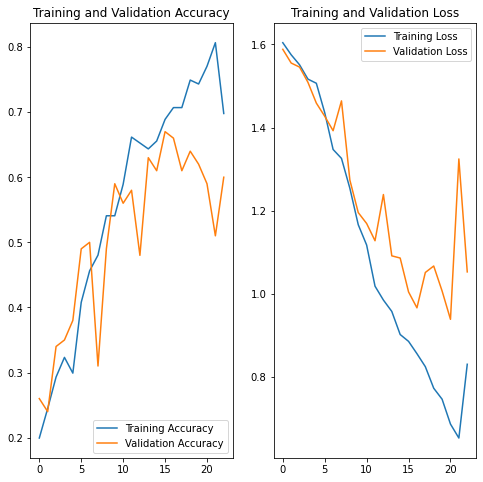

In [23]:
acc = history.history['categorical_accuracy']
val_acc = history.history['val_categorical_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(len(history.history['categorical_accuracy']))

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

### The training above will give a good model. The best model should then be loaded in the next section to fine tune

# Fine tuning
- Load model with best val accuracy from above training
- Reducing the learning rate from 0.001 to 0.00001
- Removing the beta_1 and beta_2 params for Adam

In roughly 15 epochs more we get the best model

In [17]:
from keras.models import load_model

In [18]:
best_model_path = '' # Provide path to model with best val accuarcy from above training
conv3dmodel = load_model(best_model_path)
conv3dmodel.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d (Conv3D)              (None, 15, 100, 100, 32)  800       
_________________________________________________________________
max_pooling3d (MaxPooling3D) (None, 7, 50, 50, 32)     0         
_________________________________________________________________
conv3d_1 (Conv3D)            (None, 7, 50, 50, 16)     4112      
_________________________________________________________________
max_pooling3d_1 (MaxPooling3 (None, 3, 25, 25, 16)     0         
_________________________________________________________________
conv3d_2 (Conv3D)            (None, 3, 25, 25, 8)      1032      
_________________________________________________________________
max_pooling3d_2 (MaxPooling3 (None, 1, 12, 12, 8)      0         
_________________________________________________________________
flatten (Flatten)            (None, 1152)              0

Reduce lr from 0.001 to 0.00001 and remove beta_1 and beta_2 params

In [20]:
optimiser = optimizers.Adam(learning_rate=0.00001)
loss = losses.CategoricalCrossentropy(from_logits=False)# False indicates we have used softmax and no normalisation required
conv3dmodel.compile(optimizer=optimiser, loss=loss, metrics=['categorical_accuracy'])

Let us create the `train_generator` and the `val_generator` which will be used in `.fit_generator`.

In [21]:
batch_size = 25
fraction_total_data = 1.0
train_generator = generator(train_path, train_doc, batch_size, fraction_total_data=fraction_total_data)
val_generator = generator(val_path, val_doc, batch_size)

In [22]:
curr_dt_time = datetime.datetime.now()
model_name = 'model_init_conv3d_full_data' + '_' + str(curr_dt_time).replace(' ','').replace(':','_') + '/'
    
if not os.path.exists(model_name):
    os.mkdir(model_name)
        
filepath = model_name + 'model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.h5'

checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=False, save_weights_only=False, mode='auto', period=1)

LR = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=0.000001)

earlystop = EarlyStopping(monitor='val_categorical_accuracy', min_delta=1e-3, patience=6, verbose=1, mode='max', restore_best_weights=True)

callbacks_list = [checkpoint, LR, earlystop]

The `steps_per_epoch` and `validation_steps` are used by `fit_generator` to decide the number of next() calls it need to make.

In [23]:
if ((num_train_sequences * fraction_total_data) % batch_size) == 0:
    steps_per_epoch = int((num_train_sequences * fraction_total_data)/batch_size)
else:
    steps_per_epoch = ((num_train_sequences * fraction_total_data)//batch_size) + 1

if (num_val_sequences % batch_size) == 0:
    validation_steps = int(num_val_sequences/batch_size)
else:
    validation_steps = (num_val_sequences //batch_size) + 1

Let us now fit the model. This will start training the model and with the help of the checkpoints, you'll be able to save the model at the end of each epoch.

In [24]:
history=conv3dmodel.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=100, verbose=1, 
                                  callbacks=callbacks_list, validation_data=val_generator, 
                                  validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

Epoch 1/100
27/27 [==============================] - ETA: 0s - loss: 0.2564 - categorical_accuracy: 0.9367
Epoch 00001: saving model to model_init_conv3d_full_data_2021-05-2915_16_31.110869/model-00001-0.25642-0.93665-0.42074-0.86000.h5
27/27 [==============================] - 80s 3s/step - loss: 0.2564 - categorical_accuracy: 0.9367 - val_loss: 0.4207 - val_categorical_accuracy: 0.8600
Epoch 2/100
27/27 [==============================] - ETA: 0s - loss: 0.2793 - categorical_accuracy: 0.9231
Epoch 00002: saving model to model_init_conv3d_full_data_2021-05-2915_16_31.110869/model-00002-0.27930-0.92308-0.39587-0.88000.h5
27/27 [==============================] - 78s 3s/step - loss: 0.2793 - categorical_accuracy: 0.9231 - val_loss: 0.3959 - val_categorical_accuracy: 0.8800
Epoch 3/100
27/27 [==============================] - ETA: 0s - loss: 0.2651 - categorical_accuracy: 0.9351
Epoch 00003: saving model to model_init_conv3d_full_data_2021-05-2915_16_31.110869/model-00003-0.26511-0.93514-0.

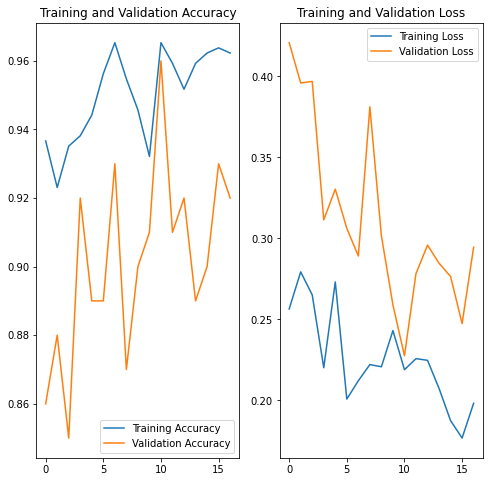

In [25]:
acc = history.history['categorical_accuracy']
val_acc = history.history['val_categorical_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(len(history.history['categorical_accuracy']))

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()